In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import charset_normalizer
import re
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Training Set
context = pd.read_csv('/kaggle/input/train-set/context.csv')
mpa = pd.read_csv('/kaggle/input/train-set/mpa.csv')
mpu = pd.read_csv('/kaggle/input/train-set/mpu.csv')
user = pd.read_csv('/kaggle/input/train-set/user.csv')

In [3]:
# Testing Set
context_test = pd.read_csv('/kaggle/input/test-set/context.csv')
mpa_test = pd.read_csv('/kaggle/input/test-set/mpa.csv')
mpu_test = pd.read_csv('/kaggle/input/test-set/mpu.csv')
user_test = pd.read_csv('/kaggle/input/test-set/user.csv')

In [4]:
user = user.drop(['Unnamed: 0'],axis = 1)
context = context.drop(['Unnamed: 0'],axis = 1)
mpa = mpa.drop(['Unnamed: 0'],axis = 1)
mpu = mpu.drop(['Unnamed: 0'],axis = 1)

user_test = user_test.drop(['Unnamed: 0'],axis = 1)
context_test = context_test.drop(['Unnamed: 0'],axis = 1)
mpa_test = mpa_test.drop(['Unnamed: 0'],axis = 1)
mpu_test = mpu_test.drop(['Unnamed: 0'],axis = 1)


In [5]:
df = user.merge(context,on='id',how ='left')
df= df.merge(mpu,on='id',how ='left')
df

,id,gender,age,education,profession,income,marital_status,continent,fb_freq,yt_freq,...,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,mobile_plan,accept
0,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,alone,sunny,afternoon,1,0,0,0,0,datasilver,1.0
1,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,alone,sunny,afternoon,1,0,0,0,0,datasilver,0.0
2,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,alone,sunny,afternoon,1,0,0,0,0,datagold,0.0
3,4297,other,22,unknown,unemployed,lower-middle,single,europe,0,0,...,friends,sunny,morning,1,1,0,0,0,socialmediagold,1.0
4,4297,other,22,unknown,unemployed,lower-middle,single,europe,0,0,...,friends,sunny,morning,1,1,0,0,0,datagold,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40695,12092,male,27,grad,employed,middle,single,europe,0,0,...,alone,sunny,morning,1,0,0,0,1,datagold,0.0
40696,12092,male,27,grad,employed,middle,single,europe,0,0,...,alone,sunny,morning,1,0,0,0,1,socialmediagold,0.0
40697,12092,male,27,grad,employed,middle,single,europe,0,0,...,alone,sunny,morning,1,0,0,0,1,datacall,0.0
40698,12092,male,27,grad,employed,middle,single,europe,0,0,...,alone,sunny,morning,1,0,0,0,1,socialmedia,0.0


## Feature engineer

### Social Media

In [6]:
def sm_ext(df, threshold):
  sm_avg_usage = df[['fb_freq', 'yt_freq', 'insta_freq']].apply(lambda x: x.sum(), axis=1)
  df['sm_ext'] = sm_avg_usage.apply(lambda x: True if x > threshold else False)

sm_ext(df, 10)
# sm_ext(df_test, 10)

### use_less_than_2GB and use_2GB_to_4GB

In [7]:
def usage_ext(df):
  usage = ['use_less_than_2GB', 'use_2GB_to_4GB']
  for x in usage:
    range = 1.5
    IQR = df[x].quantile(0.75) - df[x].quantile(0.25)
    upper_bound = df[x].quantile(0.75) + (IQR * range)

    df[f"{x}_ext"] = df[x].apply(lambda y: True if y > upper_bound else False)

usage_ext(df)
# usage_ext(df_test)

### Education

In [8]:
def education_abn(df):
  df['education_abn'] = df['education'].apply(lambda x: True if x == 'unknown' else False)

education_abn(df)
# education_abn(df_test)

### Score

In [9]:
def score_ext(df):
  range = 1.5
  IQR = df['score'].quantile(0.75) - df['score'].quantile(0.25)
  upper_bound = df['score'].quantile(0.75) + (IQR * range)

  df['score_ext'] = df['score'].apply(lambda y: True if y > upper_bound else False)

score_ext(df)
# score_ext(df_test)

In [10]:
df

,id,gender,age,education,profession,income,marital_status,continent,fb_freq,yt_freq,...,viettel_no_2,score,direction,mobile_plan,accept,sm_ext,use_less_than_2GB_ext,use_2GB_to_4GB_ext,education_abn,score_ext
0,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,0,0,0,datasilver,1.0,False,False,False,True,False
1,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,0,0,0,datasilver,0.0,False,False,False,True,False
2,11156,female,21,unknown,unemployed,lower-middle,single,oceania,0,0,...,0,0,0,datagold,0.0,False,False,False,True,False
3,4297,other,22,unknown,unemployed,lower-middle,single,europe,0,0,...,0,0,0,socialmediagold,1.0,True,False,False,True,False
4,4297,other,22,unknown,unemployed,lower-middle,single,europe,0,0,...,0,0,0,datagold,0.0,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40695,12092,male,27,grad,employed,middle,single,europe,0,0,...,0,0,1,datagold,0.0,False,False,False,False,False
40696,12092,male,27,grad,employed,middle,single,europe,0,0,...,0,0,1,socialmediagold,0.0,False,False,False,False,False
40697,12092,male,27,grad,employed,middle,single,europe,0,0,...,0,0,1,datacall,0.0,False,False,False,False,False
40698,12092,male,27,grad,employed,middle,single,europe,0,0,...,0,0,1,socialmedia,0.0,False,False,False,False,False


## Encode

In [11]:
X = df.drop(columns=['accept'])
y = df['accept']
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
continuous_cols = X.select_dtypes(include=['number']).columns

In [12]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

## Chi Square - Dùng cho biến danh mục (categorical)

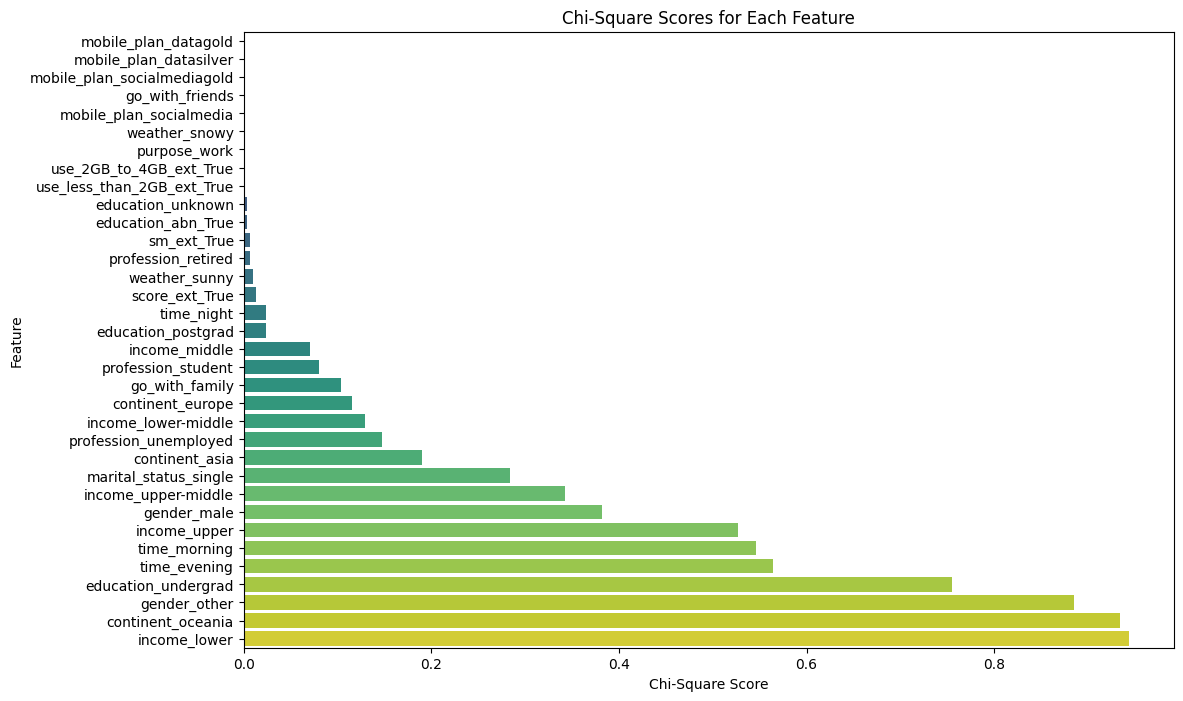

In [13]:
selector = SelectKBest(score_func=chi2, k='all')  
X_selected = selector.fit_transform(X.drop(axis=1, columns=continuous_cols), y)

scores = selector.scores_
p_values = selector.pvalues_

feature_scores_chi2 = pd.DataFrame({'Feature': X.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='p-Value', y='Feature', data=feature_scores_chi2, palette='viridis')
plt.title('Chi-Square Scores for Each Feature')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()

In [14]:
selected_features_categorical = feature_scores_chi2[feature_scores_chi2['p-Value'] < 0.05]['Feature'].tolist()

print("Các feature quan trọng:", selected_features_categorical)
print(len(selected_features_categorical))

Các feature quan trọng: ['mobile_plan_datagold', 'mobile_plan_datasilver', 'mobile_plan_socialmediagold', 'go_with_friends', 'mobile_plan_socialmedia', 'weather_snowy', 'purpose_work', 'use_2GB_to_4GB_ext_True', 'use_less_than_2GB_ext_True', 'education_unknown', 'education_abn_True', 'sm_ext_True', 'profession_retired', 'weather_sunny', 'score_ext_True', 'time_night', 'education_postgrad']
17


## ANOVA 

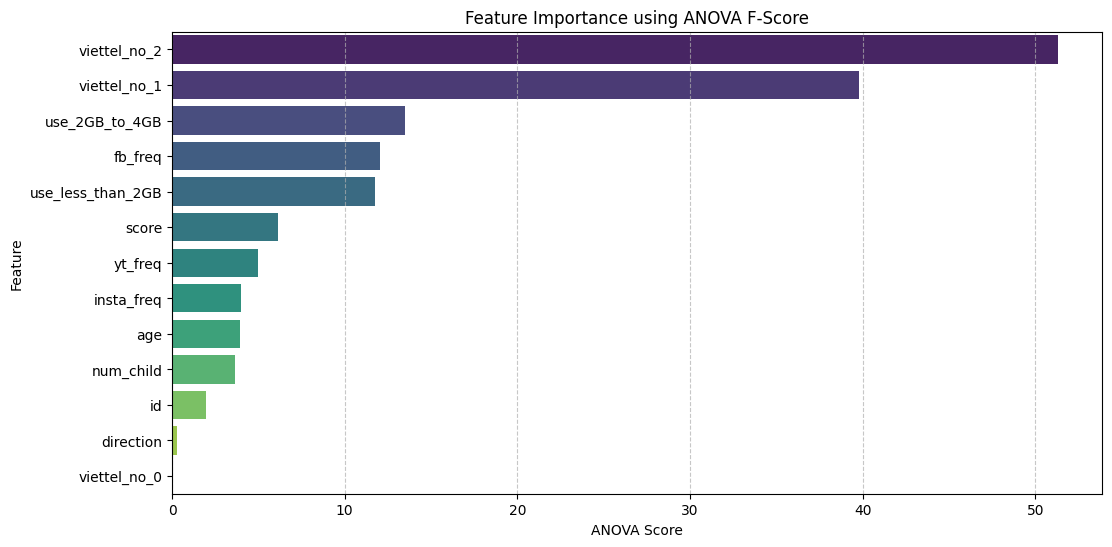

In [15]:
selector = SelectKBest(score_func=f_classif, k='all')  
X_selected = selector.fit_transform(X[continuous_cols], y)

scores = selector.scores_
p_values = selector.pvalues_

feature_scores_anova = pd.DataFrame({'Feature': X[continuous_cols].columns, 'Score': scores, 'p-Value': p_values})
feature_scores_anova = feature_scores_anova.sort_values(by='Score', ascending=False)
feature_scores_anova
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_scores_anova['Score'],
    y=feature_scores_anova['Feature'],
    palette='viridis'
)
plt.xlabel("ANOVA Score")
plt.ylabel("Feature")
plt.title("Feature Importance using ANOVA F-Score")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [16]:

selected_features_continous = feature_scores_anova[feature_scores_anova['p-Value'] < 0.05]['Feature'].tolist()

print("Các feature quan trọng:",selected_features_continous)
print(len(selected_features_continous))

Các feature quan trọng: ['viettel_no_2', 'viettel_no_1', 'use_2GB_to_4GB', 'fb_freq', 'use_less_than_2GB', 'score', 'yt_freq', 'insta_freq', 'age']
9


In [17]:
selected_features = selected_features_categorical + selected_features_continous
selected_features

['mobile_plan_datagold',
 'mobile_plan_datasilver',
 'mobile_plan_socialmediagold',
 'go_with_friends',
 'mobile_plan_socialmedia',
 'weather_snowy',
 'purpose_work',
 'use_2GB_to_4GB_ext_True',
 'use_less_than_2GB_ext_True',
 'education_unknown',
 'education_abn_True',
 'sm_ext_True',
 'profession_retired',
 'weather_sunny',
 'score_ext_True',
 'time_night',
 'education_postgrad',
 'viettel_no_2',
 'viettel_no_1',
 'use_2GB_to_4GB',
 'fb_freq',
 'use_less_than_2GB',
 'score',
 'yt_freq',
 'insta_freq',
 'age']

# Model

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [19]:
class MachineLearning:
    def __init__(self, X_train,X_valid, X_test, Y_train,Y_valid, Y_test):
        self.X_train = X_train
        self.X_valid = X_valid
        self.X_test = X_test
        
    
        self.Y_train = Y_train
        self.Y_valid = Y_valid
        self.Y_test = Y_test

        self.configs = {
            "knn": {"n_neighbors": 3, "weights": "uniform", "algorithm": "auto", "leaf_size": 30, "p": 2},
            "logistic": {"penalty": "l2", "C": 1.0, "solver": "lbfgs", "max_iter": 500},
            "mlp": {"hidden_layer_sizes": (100,), "activation": "relu", "solver": "adam", "max_iter": 500},
            "decisiontree": {"criterion": "gini", "max_depth": None, "min_samples_split": 2},
            "randomforest": {"n_estimators": 500, "criterion": "gini", "max_depth": None, "min_samples_split": 2},
            "xgboost": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3, "verbosity": 1},
            "gradientboosting": {"loss": "log_loss", "learning_rate": 0.1, "n_estimators": 100, "subsample": 1.0},
            "extratrees": {"n_estimators": 50, "max_depth": None, "min_samples_split": 2, "random_state": 42},
            "lightgbm": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": -1, "num_leaves": 31, "random_state": 42},
            "catboost": {"iterations": 100, "learning_rate": 0.1, "depth": 6, "verbose": False},
            "svc": {"C": 1.0, "kernel": "rbf", "gamma": "scale"},
            "naivebayes": {"var_smoothing": 1e-9}  # Added Naive Bayes
        }
        
        self.param_grids = {
            "knn": {
                "n_neighbors": [3, 5, 7, 9],
                "weights": ["uniform", "distance"],
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10, 30, 50, 100],
                "p": [1, 2]
            },
            "logistic": {
                "penalty": ["l1", "l2", "elasticnet"],
                "C": [0.001, 0.01, 0.1, 1.0, 10.0],
                "solver": ["liblinear", "lbfgs", "saga"],
                "max_iter": [100, 200, 500]
            },
            "decisiontree": {
                "criterion": ["gini", "entropy"],
                "max_depth": [None, 10, 20, 30, 40, 50],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            },
            "randomforest": {
                "n_estimators": [100, 200, 300],
                "criterion": ["gini", "entropy"],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False]
            },
            "xgboost": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [3, 5, 7],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            },
            "gradientboosting": {
                "loss": ["log_loss", "exponential"],
                "learning_rate": [0.01, 0.1, 0.2],
                "n_estimators": [100, 200, 300],
                "max_depth": [3, 5, 7],
                "subsample": [0.6, 0.8, 1.0],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            },
            "mlp": {
                "hidden_layer_sizes": [(50,), (100,), (100, 50), (100, 100)],
                "activation": ["relu", "tanh", "logistic"],
                "solver": ["adam", "sgd"],
                "alpha": [0.0001, 0.001, 0.01],
                "learning_rate": ["constant", "adaptive"],
                "max_iter": [200, 300, 400]
            },
            "lightgbm": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [-1, 5, 10, 15],
                "num_leaves": [31, 50, 100],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            },
            "catboost": {
                "iterations": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "depth": [4, 6, 8, 10],
                "l2_leaf_reg": [1, 3, 5, 7],
                "border_count": [32, 64, 128]
            },
            "svc": {
                "C": [0.1, 1.0, 10.0, 100.0],
                "kernel": ["linear", "rbf", "poly"],
                "gamma": ["scale", "auto", 0.1, 1],
                "degree": [2, 3, 4]
            },
            "extratrees": {
                "n_estimators": [100, 200, 300],
                "criterion": ["gini", "entropy"],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False]
            },
            "naivebayes": {  # Added parameter grid for Naive Bayes
                "var_smoothing": [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
            }
        }

    def create_model(self, model_name):
        if model_name not in self.configs:
            raise ValueError(f"Model '{model_name}' không được hỗ trợ.")
        try:
            model_class = {
                "knn": KNeighborsClassifier,
                "logistic": LogisticRegression,
                "decisiontree": DecisionTreeClassifier,
                "randomforest": RandomForestClassifier,
                "xgboost": XGBClassifier,
                "gradientboosting": GradientBoostingClassifier,
                "mlp": MLPClassifier,
                "extratrees": ExtraTreesClassifier,
                "lightgbm": LGBMClassifier,
                "catboost": CatBoostClassifier,
                "svc": SVC,
                "naivebayes": GaussianNB  # Added Naive Bayes
            }[model_name]
            return model_class(**self.configs[model_name])
        except KeyError:
            raise ValueError(f"Model '{model_name}' không tồn tại.")

    def update_config(self, model_name, new_config):
        if model_name in self.configs:
            self.configs[model_name] = {**self.configs[model_name], **new_config}
        return self.create_model(model_name)

    def confusion_matrix_plot(self, model_name):
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        y_pred = model.predict(self.X_test)
        cm = confusion_matrix(self.Y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
        plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("Actual", fontsize=14)
        plt.tight_layout()
        plt.show()

    def run_model(self, model_name,valid = True):
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        X_test, Y_test = (self.X_valid, self.Y_valid) if valid else (self.X_test, self.Y_test)
        y_pred = model.predict(X_test)
        print(f"\nPerformance for {model_name}:")
        print(f"Config: {self.configs[model_name]}")
        print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(Y_test, y_pred, average='weighted'):.4f}")
        print(f"Recall: {recall_score(Y_test, y_pred, average='weighted'):.4f}")
        print(f"F1 Score: {f1_score(Y_test, y_pred, average='weighted'):.4f}")
        cm = confusion_matrix(Y_test, y_pred)
        name = ''
        if valid == True:
            name = 'Valid Set'
        else : name = 'Test Set'
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
        plt.title(f"Confusion Matrix for {name}", fontsize=16)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("Actual", fontsize=14)
        plt.tight_layout()
        plt.show()
        
    def random_search_for_single_model(self, model_name, cv=5, scoring='accuracy', verbose=1, n_iter=30, random_state=42):
        if model_name not in self.configs:
            raise ValueError(f"Model '{model_name}' not recognized. Available models: {list(self.configs.keys())}")
    
        model = self.create_model(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found in the class instance.")
    
        param_distributions = self.param_grids.get(model_name, None)
        if param_distributions is None:
            raise ValueError(f"No parameter grid defined for model '{model_name}'.")
    
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=verbose,
            random_state=random_state
        )
    
        print(f"Starting Randomized Search for model '{model_name}'...")
        randomized_search.fit(self.X_train, self.Y_train)
    
        best_params = randomized_search.best_params_
        best_score = randomized_search.best_score_
    
        print(f"Best Parameters for {model_name}: {best_params}")
        print(f"Best Cross-Validation {scoring}: {best_score:.4f}")

        return self.update_config(model_name, best_params)

    def compare_models(self, models,valid = True):
        performance_data = []
        if valid == True:
            X_test = self.X_valid
            Y_test = self.Y_valid
        else :
            X_test = self.X_test
            Y_test = self.Y_test
        for model_name in models:
            model = self.create_model(model_name)
            if model is None:
                print(f"Model '{model_name}' not found. Skipping.")
                continue
            try:
                model.fit(self.X_train, self.Y_train)
                y_pred = model.predict(X_test)

                metrics = {
                    "Model": model_name.upper(),
                    "Accuracy": accuracy_score(Y_test, y_pred),
                    "Precision": precision_score(Y_test, y_pred, average='weighted'),
                    "Recall": recall_score(Y_test, y_pred, average='weighted'),
                    "F1 Score": f1_score(Y_test, y_pred, average='weighted')
                }
                performance_data.append(metrics)
            except Exception as e:
                print(f"Error evaluating model '{model_name}': {e}")
                continue
        
        performance_df = pd.DataFrame(performance_data)
        performance_df.sort_values(by="Accuracy", ascending=False, inplace=True)
        return performance_df

    def get_results(self, models):
        performance_data = []

        for model_name in models:
            model = self.create_model(model_name)
            if model is None:
                print(f"Model '{model_name}' not found. Skipping.")
                continue
            try:
                model.fit(self.X_train, self.Y_train)
                y_pred = model.predict(self.X_test)

                metrics = {
                    "Model": model_name.upper(),
                    'result': y_pred
                }
                performance_data.append(metrics)
            except Exception as e:
                print(f"Error evaluating model '{model_name}': {e}")
                continue
        
        return performance_data

# Test Model without Feature Selection

## Approach 1

In [20]:
def preprocess_data_approach1(user,context,mpu, resample = False):
    df = user.merge(context,on='id',how ='left')
    df= df.merge(mpu,on='id',how ='left')
    X = df.drop(columns=['accept','gender'])
    y = df['accept']
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
    continuous_cols = X.select_dtypes(include=['number']).columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)
    if resample == True:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X, y = smote.fit_resample(X, y)
    return X,y
    

### NOT Resample

In [21]:
X,y = preprocess_data_approach1(user, context, mpu)
X_test,y_test = preprocess_data_approach1(user_test, context_test, mpu_test)
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state =42)

In [22]:
ml_ap1 = MachineLearning(X_train,X_valid,X_test,y_train,y_valid,y_test)

#### Valid Set

In [23]:
ml_ap1.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'])

,Model,Accuracy,Precision,Recall,F1 Score
1,LOGISTIC,0.818305,0.669623,0.818305,0.736535
5,XGBOOST,0.818305,0.669623,0.818305,0.736535
8,CATBOOST,0.818305,0.669623,0.818305,0.736535
6,GRADIENTBOOSTING,0.817813,0.669549,0.817813,0.736292
2,MLP,0.815479,0.723087,0.815479,0.738744
9,NAIVEBAYES,0.804054,0.717589,0.804054,0.741406
4,RANDOMFOREST,0.798649,0.746415,0.798649,0.760801
7,EXTRATREES,0.794840,0.744770,0.794840,0.759998
0,KNN,0.786241,0.726389,0.786241,0.746936
3,DECISIONTREE,0.736118,0.729616,0.736118,0.732787


#### Test set

In [24]:
ml_ap1.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'],False)

,Model,Accuracy,Precision,Recall,F1 Score
4,RANDOMFOREST,0.577295,0.756118,0.577295,0.423443
1,LOGISTIC,0.576490,0.332340,0.576490,0.421621
5,XGBOOST,0.576490,0.332340,0.576490,0.421621
2,MLP,0.576490,0.332340,0.576490,0.421621
8,CATBOOST,0.576490,0.332340,0.576490,0.421621
7,EXTRATREES,0.575684,0.536294,0.575684,0.437766
6,GRADIENTBOOSTING,0.574879,0.331946,0.574879,0.420873
9,NAIVEBAYES,0.571659,0.498312,0.571659,0.434400
0,KNN,0.563607,0.517010,0.563607,0.475584
3,DECISIONTREE,0.555556,0.526171,0.555556,0.513535


### Resample


In [25]:
X,y = preprocess_data_approach1(user, context, mpu,True)
X_test,y_test = preprocess_data_approach1(user_test, context_test, mpu_test,True)
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state =42)

In [26]:
ml_ap1 = MachineLearning(X_train,X_valid,X_test,y_train,y_valid,y_test)

#### Model test on Valid set

In [27]:
ml_ap1.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'])

,Model,Accuracy,Precision,Recall,F1 Score
4,RANDOMFOREST,0.883175,0.889845,0.883175,0.882752
7,EXTRATREES,0.877794,0.882422,0.877794,0.877492
6,GRADIENTBOOSTING,0.865162,0.894007,0.865162,0.862838
8,CATBOOST,0.864639,0.893684,0.864639,0.862287
5,XGBOOST,0.862097,0.892122,0.862097,0.859605
3,DECISIONTREE,0.838030,0.838031,0.838030,0.838030
0,KNN,0.766350,0.766511,0.766350,0.766347
2,MLP,0.646012,0.661633,0.646012,0.638270
1,LOGISTIC,0.642948,0.643218,0.642948,0.642901
9,NAIVEBAYES,0.640706,0.662831,0.640706,0.626749


#### Model test on Test set

In [28]:
ml_ap1.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'],False)

,Model,Accuracy,Precision,Recall,F1 Score
9,NAIVEBAYES,0.625000,0.625797,0.625000,0.624405
7,EXTRATREES,0.624302,0.737227,0.624302,0.573552
8,CATBOOST,0.620810,0.784353,0.620810,0.557132
6,GRADIENTBOOSTING,0.620810,0.784353,0.620810,0.557132
4,RANDOMFOREST,0.620810,0.778812,0.620810,0.558221
5,XGBOOST,0.620112,0.784127,0.620112,0.556042
3,DECISIONTREE,0.614525,0.637373,0.614525,0.597802
1,LOGISTIC,0.589385,0.593961,0.589385,0.584325
2,MLP,0.569134,0.607853,0.569134,0.526652
0,KNN,0.501397,0.501418,0.501397,0.499507



Performance for randomforest:
Config: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.8829
Precision: 0.8897
Recall: 0.8829
F1 Score: 0.8824


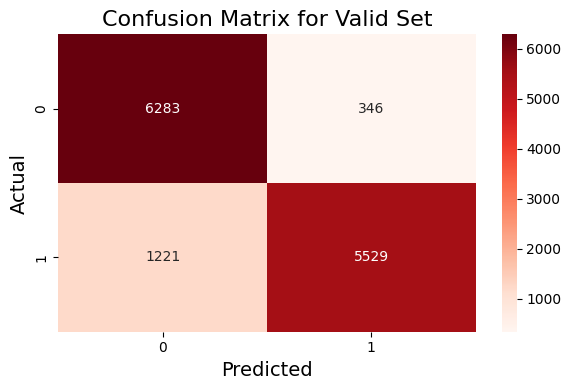

In [29]:
# Test in Valid set
ml_ap1.run_model('randomforest',True)


Performance for randomforest:
Config: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.6222
Precision: 0.7848
Recall: 0.6222
F1 Score: 0.5593


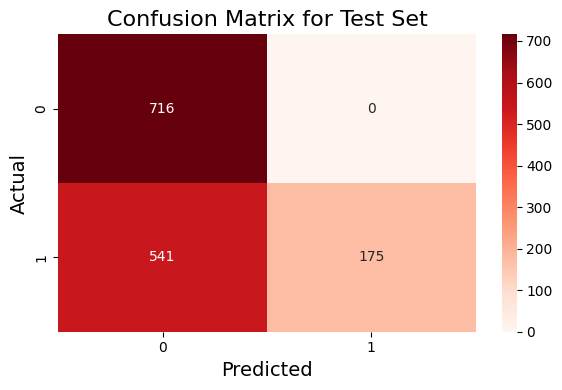

In [30]:
ml_ap1.run_model('randomforest',False)

## Approach 2

### Data Preparing

In [31]:
def preprocess_data(context, user, mpu,resample = False):
    mobile_plans = mpu.mobile_plan.unique()
    eda_df = user.merge(context, on="id", how="left")
    df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
    temp_df = eda_df.merge(df_mobile_plan, how='cross')  
    df = temp_df.merge(mpu, on=['id', 'mobile_plan'], how='left')
    df = df.fillna(0)
    df = df.drop_duplicates(subset=['id', 'mobile_plan'])
    X = df.drop(columns=['accept','gender'])
    y = df['accept']
    X['mobile_plan'] = X['mobile_plan'].astype('category')
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
    continuous_cols = X.select_dtypes(include=['number']).columns

    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    X = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)
    if resample == True:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X, y = smote.fit_resample(X, y)

    return (X,y)


### NOT resample

In [32]:
X, y = preprocess_data(context, user, mpu)
X_test, y_test = preprocess_data(context_test, user_test, mpu_test)
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state =42)
ml_ap2 = MachineLearning(X_train,X_valid,X_test,y_train,y_valid,y_test)


### Model on Valid Set

In [33]:

ml_ap2.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'])

,Model,Accuracy,Precision,Recall,F1 Score
1,LOGISTIC,0.892931,0.797326,0.892931,0.842425
2,MLP,0.892931,0.797326,0.892931,0.842425
6,GRADIENTBOOSTING,0.892931,0.797326,0.892931,0.842425
5,XGBOOST,0.892931,0.797326,0.892931,0.842425
8,CATBOOST,0.892845,0.797318,0.892845,0.842382
4,RANDOMFOREST,0.892758,0.837642,0.892758,0.842840
7,EXTRATREES,0.889993,0.836356,0.889993,0.846809
9,NAIVEBAYES,0.880142,0.812059,0.880142,0.839878
0,KNN,0.878500,0.805000,0.878500,0.837334
3,DECISIONTREE,0.814293,0.828441,0.814293,0.821108


### Model on Test Set

In [34]:
ml_ap2.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'],False)

,Model,Accuracy,Precision,Recall,F1 Score
7,EXTRATREES,0.916727,0.889064,0.916727,0.881829
1,LOGISTIC,0.916007,0.839069,0.916007,0.875852
6,GRADIENTBOOSTING,0.916007,0.839069,0.916007,0.875852
5,XGBOOST,0.916007,0.839069,0.916007,0.875852
8,CATBOOST,0.916007,0.839069,0.916007,0.875852
4,RANDOMFOREST,0.915827,0.839055,0.915827,0.875762
9,NAIVEBAYES,0.910612,0.846065,0.910612,0.874129
2,MLP,0.907014,0.856202,0.907014,0.875823
0,KNN,0.901259,0.846729,0.901259,0.871020
3,DECISIONTREE,0.831295,0.862702,0.831295,0.845915


#### Resample

In [35]:
X, y = preprocess_data(context, user, mpu,True)
X_test, y_test = preprocess_data(context_test, user_test, mpu_test,True)
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state =42)
ml_ap2 = MachineLearning(X_train,X_valid,X_test,y_train,y_valid,y_test)


#### Valid Set

In [36]:

ml_ap2.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'])

,Model,Accuracy,Precision,Recall,F1 Score
4,RANDOMFOREST,0.941479,0.947303,0.941479,0.941246
8,CATBOOST,0.939395,0.945880,0.939395,0.939129
7,EXTRATREES,0.938863,0.942945,0.938863,0.938685
6,GRADIENTBOOSTING,0.938572,0.945224,0.938572,0.938295
5,XGBOOST,0.935956,0.943154,0.935956,0.935644
3,DECISIONTREE,0.894051,0.894295,0.894051,0.894051
0,KNN,0.858153,0.864661,0.858153,0.857384
2,MLP,0.676243,0.705459,0.676243,0.665559
9,NAIVEBAYES,0.671834,0.701940,0.671834,0.660446
1,LOGISTIC,0.659384,0.659956,0.659384,0.659278


#### Test set

In [37]:

ml_ap2.compare_models(['knn','logistic','mlp','decisiontree','randomforest','xgboost','gradientboosting','extratrees','catboost','naivebayes'])

,Model,Accuracy,Precision,Recall,F1 Score
4,RANDOMFOREST,0.941672,0.947500,0.941672,0.941440
8,CATBOOST,0.939395,0.945880,0.939395,0.939129
7,EXTRATREES,0.938863,0.942945,0.938863,0.938685
6,GRADIENTBOOSTING,0.938572,0.945224,0.938572,0.938295
5,XGBOOST,0.935956,0.943154,0.935956,0.935644
3,DECISIONTREE,0.891968,0.892240,0.891968,0.891967
0,KNN,0.858153,0.864661,0.858153,0.857384
9,NAIVEBAYES,0.671834,0.701940,0.671834,0.660446
1,LOGISTIC,0.659384,0.659956,0.659384,0.659278
2,MLP,0.602606,0.664894,0.602606,0.557746


## RandomForest Classisfier


Performance for randomforest:
Config: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.9418
Precision: 0.9476
Recall: 0.9418
F1 Score: 0.9415


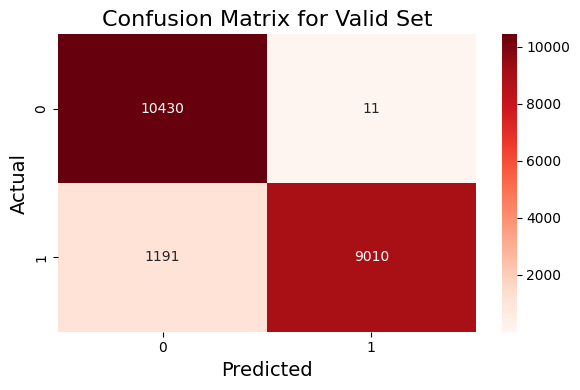

In [38]:
# RandomForest on Valid set
ml_ap2.run_model('randomforest',True)


Performance for randomforest:
Config: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.9527
Precision: 0.9567
Recall: 0.9527
F1 Score: 0.9526


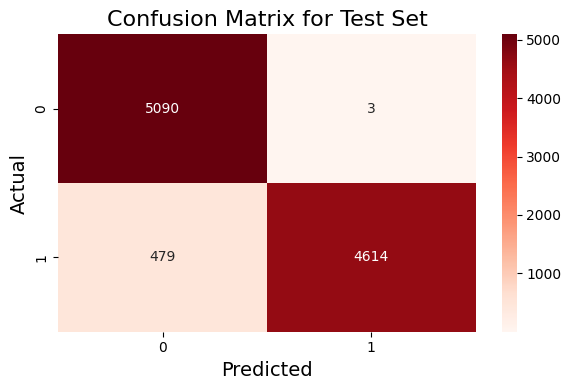

In [39]:
# RandomForest on Test set
ml_ap2.run_model('randomforest',False)

### Cross Valid for RF

In [40]:
# ml_ap2.random_search_for_single_model('randomforest')

Best Parameters for randomforest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}

In [47]:
ml_ap2.update_config('randomforest',{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False})

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       min_samples_leaf=2)


Performance for randomforest:
Config: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}
Accuracy: 0.9531
Precision: 0.9570
Recall: 0.9531
F1 Score: 0.9530


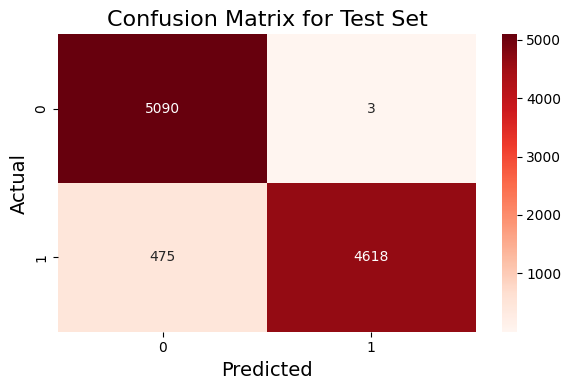

In [48]:
ml_ap2.run_model('randomforest',False)